In [25]:
import os
import json
import pylab
import inspect
import zipfile 
import numpy as np
from copy import copy
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from distributions.distribution_output import BernoulliOutput

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [21]:
# some helper functions to plot test metrics
def plot_precision_recall(y_true, y_prob, class_mapper, class_count):   
    
         
        # Compute ROC curve and ROC area for each class
        precision = dict()
        recall = dict()
        average_precision = dict()
        n_classes = y_true.shape[-1]
        class_labels = {}
        
                
        for c in class_mapper:
            class_labels[class_mapper[c]] = str(c)
        
        
        
        lw = 1
        average = 'weighted'
        # A "weighted-average": quantifying score on all classes jointly
        precision[average], recall[average], _ = precision_recall_curve(y_true.ravel(), y_prob.ravel())
        average_precision[average] = average_precision_score(y_true, y_prob, average=average)
        
        
         
        plt.figure()
        plt.plot(recall[average], precision[average],
                 lw=lw, label=average+'-average precision: AP={0:0.2f}'.format(average_precision[average]))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="lower right")
        plt.show()
        

def plot_roc_results(y_true, y_prob,  class_mapper , class_count):   
    
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        n_classes = y_true.shape[-1]
        class_labels = {}
        
                
        for c in class_mapper:
            class_labels[class_mapper[c]] = str(c)
        
      
        lw = 1
        for i in range(n_classes):
        
            if np.sum(y_true[:, i])/y_true.shape[0] > 0.000:
                fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_prob[:, i])
                roc_auc[i] = roc_auc_score(y_true[:, i], y_prob[:, i]) 
                
        fig, ax = plt.subplots()
        z = class_count*1./sum(class_count)
        y = [roc_auc[i] for i in roc_auc]
        ax.scatter(z, y)

        for c in class_mapper:
            i = class_mapper[c]
            ax.annotate(c, (z[i], y[i]))
                
        #plt.figure()
        #plt.scatter(class_count*1./sum(class_count), [roc_auc[i] for i in roc_auc])
        plt.xlabel('Proportion in data')
        plt.ylabel('AUC')
        plt.title('')

        plt.figure()
        average = 'weighted'
        
        all_fpr = np.unique(np.concatenate([fpr[i] for i in fpr.keys()]))
    
        
        
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in fpr.keys():
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= len(fpr.keys())

        fpr[average ] = all_fpr
        tpr[average ] = mean_tpr
        
        # Compute micro-average ROC curve and ROC area
        roc_auc[average] = roc_auc_score(y_true, y_prob, average = 'weighted')
        
        
        
        
        plt.figure()
        plt.plot(fpr[average], tpr[average],
                 lw=lw, label='Average ROC curve (area = %0.2f)' % roc_auc[average])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        
        plt.show()
        
        

In [4]:
# a utility function to assign a default value to missing attributes in data
def get_default_attribute_val(attribute, numerical_attributes):
    
    attr_val = 'UNK'
    
    if attribute in numerical_attributes:
        attr_val = 0
    
    return attr_val


In [5]:
# this function parses raw json data to extract and return selected attributes in a structured (nested list) format.
# the function also maintains and returns a (dict type) distribution of observed values of the extracted attributes
def parse_attributes(rec_list, attribute_list, numerical_attributes, attribute_dstr = {}):
    all_attributes = []
    
    for cur_rec in rec_list:
        cur_rec_attributes = []
                
        for attr in attribute_list:
            
            if type(attr) == dict:
                
                for key in attr:
                    sub_rec = [{}]
                    if key in cur_rec:
                        sub_rec = cur_rec[key]
                        if type(sub_rec) == dict:
                            sub_rec = [sub_rec]
                            
                    sub_attributes, attribute_dstr = parse_attributes(sub_rec, attr[key], numerical_attributes, attribute_dstr)
                    
                    if len(sub_attributes) == 1:
                        sub_attributes = sub_attributes[0]
                    cur_rec_attributes.append(sub_attributes)
            else:
                                
                if attr in cur_rec:
                    attr_val = cur_rec[attr].lower().strip().strip('.').strip(',').strip(';')
                else:
                    attr_val = get_default_attribute_val(attr, numerical_attributes)
                
                
                cur_rec_attributes.append(attr_val)
                
                if attr not in numerical_attributes:
                
                    if attr not in attribute_dstr:
                        attribute_dstr[attr] = {}

                    try:
                        attribute_dstr[attr][attr_val] += 1
                    except KeyError:
                        attribute_dstr[attr][attr_val] = 1
                
        if len(cur_rec_attributes) == 1:
            cur_rec_attributes = cur_rec_attributes[0]
        
        all_attributes.append(cur_rec_attributes)
                
    return all_attributes, attribute_dstr
                

In [6]:
# data attributes we want to use 

# the target varaible indicating advers reactions of which we want to predict the probabilities of given an  
# event record
reaction_var = 'reactionmeddrapt'

# drug attributes we want to use in our model
drug_attr = ['drugcharacterization', 'medicinalproduct', 
               {'activesubstance': ['activesubstancename']}, 
               'drugindication']

# patient attributes we will use in our model
patient_attr = ['patientonsetage', 'patientweight', 
                 'patientsex',  'patientagegroup', 
                 'patientonsetageunit']

# keys used in json to indicate patient, reaction and drug info.
patient_key = 'patient'
reaction_key = 'reaction'
drug_key = 'drug'

#index of reaction and drug attributes in parsed data
reaction_ind = -1
drug_ind = -2

# hierarchy of atributes for parsing json
attribute_list = [{patient_key: patient_attr + [{drug_key : drug_attr}, {reaction_key : [reaction_var]}]}]

# attributes we will treat as continuous. The rest of the selected (patient and drug) attributes will be taken to be categrical
numerical_attributes = ['patientonsetage',  'patientweight']


In [7]:
# parse zip data archives downloaded from https://download.open.fda.gov/drug/event/2019q4/. We restricted 
# ourselves to 2019 Q4 data only due to resource limitations. 
directory = os.fsencode('./drug-event-data/')
parsed_data = []
attribute_dstr = {}
for file in os.listdir(directory):
    if os.fsdecode(file).endswith(".zip"): 
        print(str(directory+file))
        with zipfile.ZipFile((directory+file).decode('utf-8')) as z:
                        
            for filename in z.namelist(): 
                
                print(filename)  
                with z.open(filename) as f:
                    data = json.load(f)
                    cur_data, attribute_dstr = parse_attributes(data['results'], attribute_list, numerical_attributes, attribute_dstr)
                    parsed_data += cur_data
        

b'./drug-event-data/drug-event-0009-of-0032.json.zip'
drug-event-0009-of-0032.json
b'./drug-event-data/drug-event-0001-of-0032.json.zip'
drug-event-0001-of-0032.json
b'./drug-event-data/drug-event-0021-of-0032.json.zip'
drug-event-0021-of-0032.json
b'./drug-event-data/drug-event-0004-of-0032.json.zip'
drug-event-0004-of-0032.json
b'./drug-event-data/drug-event-0010-of-0032.json.zip'
drug-event-0010-of-0032.json
b'./drug-event-data/drug-event-0007-of-0032.json.zip'
drug-event-0007-of-0032.json
b'./drug-event-data/drug-event-0006-of-0032.json.zip'
drug-event-0006-of-0032.json
b'./drug-event-data/drug-event-0025-of-0032.json.zip'
drug-event-0025-of-0032.json
b'./drug-event-data/drug-event-0013-of-0032.json.zip'
drug-event-0013-of-0032.json
b'./drug-event-data/drug-event-0032-of-0032.json.zip'
drug-event-0032-of-0032.json
b'./drug-event-data/drug-event-0020-of-0032.json.zip'
drug-event-0020-of-0032.json
b'./drug-event-data/drug-event-0023-of-0032.json.zip'
drug-event-0023-of-0032.json
b'./

In [8]:
# select the top_k most observed reactions from data
attribute_dstr[reaction_var]
reaction_count = np.array(list(attribute_dstr[reaction_var].values()))
reaction_names = np.array(list(attribute_dstr[reaction_var].keys()))
srtd_inds = np.argsort(reaction_count)[::-1]
top_k = 30
sel_reaction_inds = srtd_inds[:top_k]
sel_reaction_list = reaction_names[sel_reaction_inds]

In [9]:
# Here we create an attribute mapper to map all categorical attributes to numerical index values, which 
# will be required for input embedding of the attributes in the model
attribute_mapper = {attr: list(attribute_dstr[attr].keys()) for attr in attribute_dstr}
for attr in attribute_mapper:
    if get_default_attribute_val(attr, numerical_attributes) not in attribute_mapper[attr]:
        attribute_mapper[attr].append(get_default_attribute_val(attr, numerical_attributes))
attribute_mapper[reaction_var] = list(sel_reaction_list)

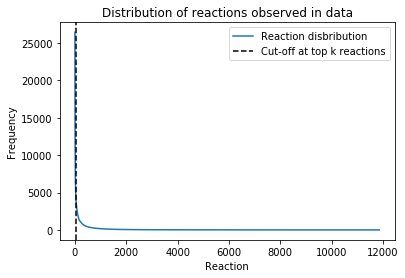

In [10]:
# the distribution of reactions observed in the data
pylab.plot(reaction_count[srtd_inds])
pylab.title('Distribution of reactions observed in data')
pylab.ylabel('Frequency')
pylab.xlabel('Reaction')
pylab.axvline(x=top_k, color='k', linestyle='--')
pylab.legend(['Reaction disbribution','Cut-off at top k reactions'])

Selected reactions
['drug ineffective' 'off label use' 'fatigue' 'death' 'nausea' 'diarrhoea'
 'headache' 'pain' 'dyspnoea' 'malaise' 'product dose omission'
 'dizziness' 'rash' 'vomiting' 'arthralgia' 'pneumonia'
 'product use in unapproved indication' 'pyrexia' 'asthenia' 'pruritus'
 'fall' 'condition aggravated' 'alopecia' 'cough' 'drug hypersensitivity'
 'anxiety' 'pain in extremity' 'weight decreased' 'acute kidney injury'
 'nasopharyngitis']


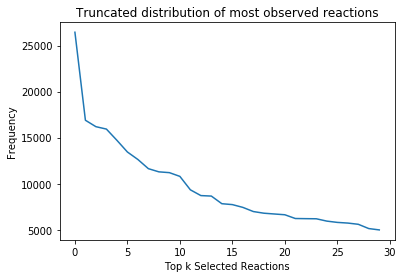

In [11]:
# truncated distribution of top_k most observed reactions in data
pylab.plot(reaction_count[sel_reaction_inds])
pylab.title('Truncated distribution of most observed reactions')
pylab.ylabel('Frequency')
pylab.xlabel('Top k Selected Reactions')
print('Selected reactions')
print(sel_reaction_list)

In [12]:
# reduce the parsed data to records containing top_k reactions
sel_inds = []
max_num_drugs = 0

for n, rec in enumerate(parsed_data):
    rec[reaction_ind] = list(set(rec[reaction_ind]) & set(sel_reaction_list))
    if len(rec[reaction_ind]) > 0 and len(rec[drug_ind]) <= 30:
        max_num_drugs = np.max([max_num_drugs,len(rec[drug_ind])])
        sel_inds.append(n)

In [13]:
# create dataset that will prepare and feed data to our model
class CustomDataset(Dataset):
    SPLIT_TRAIN = 'train'
    SPLIT_VALIDATE = 'validate'
    SPLIT_TEST = 'test'
    
    def __init__(self, raw_data, 
                    patient_attr_info, 
                    drug_attr_info, 
                    reaction_var_info, 
                    attribute_mapper, 
                    max_num_drugs,
                    split=SPLIT_TRAIN, 
                    data_splits = {SPLIT_TRAIN : 0.8, SPLIT_VALIDATE: 0.1, SPLIT_TEST: 0.1}):
        super().__init__()
        
        self.patient_attr = patient_attr_info[0]
        self.patient_attr_ind = patient_attr_info[1]
         
        self.drug_attr = drug_attr_info[0]
        self.drug_attr_ind = drug_attr_info[1]
                 
        self.reaction_var = reaction_var_info[0]
        self.reaction_var_ind = reaction_var_info[1]
                 
        self.attribute_mapper = attribute_mapper
                 
        self.max_num_drugs = max_num_drugs
        
        self.split = split
        
        self.data_splits = data_splits
                 
                 
        self.data, self.embedded_attributes, self.drug_mask_key = self.embed_data(raw_data, 
                   self.patient_attr, self.patient_attr_ind,
                   self.drug_attr, self.drug_attr_ind, 
                   self.reaction_var, self.reaction_var_ind, 
                   self.attribute_mapper, self.max_num_drugs)

        rand_perm = np.random.permutation(len(self.data))
        
        N_train = int(rand_perm.size*self.data_splits[self.SPLIT_TRAIN])
        N_validate = int(rand_perm.size*self.data_splits[self.SPLIT_VALIDATE])
        N_test = rand_perm.size - N_train - N_validate
        
        self.split_inds = {
            self.SPLIT_TRAIN : rand_perm[:N_train],
            self.SPLIT_VALIDATE : rand_perm[N_train:N_train+N_validate],
            self.SPLIT_TEST : rand_perm[N_validate:]
        }
                 
                 
    def embed_attribute_vector(self, value_list, attribute_list, attribute_mapper):
        embedded_attributes = []
        for i, attr in enumerate(attribute_list):

            attr_embedding = value_list[i]

            if attr in attribute_mapper:
                attr_embedding = attribute_mapper[attr].index(attr_embedding)
            else:
                attr_embedding = float(attr_embedding)

            embedded_attributes.append(attr_embedding)

        return embedded_attributes


    def embed_data(self, raw_data, patient_attr, patient_ind, drug_attr, drug_ind, 
                   reaction_var, reaction_ind, attribute_mapper, max_num_drugs):

        default_drug_attributes = [get_default_attribute_val(attr, numerical_attributes) for attr in drug_attr]
        default_emb_drug_attributes = self.embed_attribute_vector(default_drug_attributes, drug_attr, attribute_mapper)
        
        drug_mask_key = 'drug_mask_key'

        embedded_attributes = patient_attr + drug_attr + [drug_mask_key , reaction_var]
        
        embedded_data = []
        
        for x in raw_data:
            
            embedded_attr_vals = self.embed_attribute_vector(x[patient_ind:len(patient_attr)], 
                                                             patient_attr, attribute_mapper)

            patient_drug_list = x[drug_ind]
            if type(patient_drug_list[0]) != list:
                   patient_drug_list = [patient_drug_list]

            embedded_drug_attributes = [default_emb_drug_attributes for i in range(max_num_drugs)]
            drug_list_mask = [0 for i in range(max_num_drugs)]

            for i, d_attr in enumerate(patient_drug_list):
                embedded_drug_attributes[i] = self.embed_attribute_vector(d_attr, drug_attr, attribute_mapper)
                drug_list_mask[i] = 1.
                
            for l in list(map(list, zip(*embedded_drug_attributes))):
                embedded_attr_vals.append(l)
                
            embedded_attr_vals.append(drug_list_mask)
                
            patient_reaction = [0 for i in range(len(attribute_mapper[reaction_var]))]
            for r in x[reaction_ind]:
                patient_reaction[attribute_mapper[reaction_var].index(r)] = 1

            embedded_attr_vals.append(patient_reaction)
            
            embedded_data.append(embedded_attr_vals)
            
        return embedded_data, embedded_attributes, drug_mask_key

        
        
    def __len__(self):
        return self.split_inds[self.split].size

    def __getitem__(self, index):
        
        item = self.data[self.split_inds[self.split][index]]
        return {i[0]:i[1] for i in zip(self.embedded_attributes, item)}
    
    

In [14]:
# our model that given a (set of) drug(s) and patient predicts the adverse reaction the pateint may observe 
class ReactionPredictor(nn.Module):
    
        
    def __init__(self, patient_attr, drug_attr, reaction_var, drug_mask_key, attribute_mapper, act = nn.ReLU):

        super().__init__()
        
        
        self.patient_attr = patient_attr
        self.drug_attr = drug_attr
        self.reaction_var = reaction_var
        self.drug_mask_key = drug_mask_key
        self.attribute_mapper = attribute_mapper
        
        self.output = {}
        
        self.dim_arg_proj = 32
        self.num_hidden = 16
        self.drug_embedder_output_dim = 32
        self.patient_embedder_output_dim = 16
        
        # get input embeddings for all categorical attributes
        self.input_embeddings, self.patient_embedder_input_dim = self.get_embedding_layers(patient_attr, self.attribute_mapper)        
        drug_inp_embeddings, self.drug_embedder_input_dim = self.get_embedding_layers(drug_attr, self.attribute_mapper)
            
        self.input_embeddings.update(drug_inp_embeddings)
        
        # patient encoding sub network
        self.patient_embedder = nn.Sequential(
            nn.Linear(self.patient_embedder_input_dim, self.num_hidden),
            act(),
            nn.Linear(self.num_hidden, self.num_hidden),
            act(),
            nn.Linear(self.num_hidden, self.patient_embedder_output_dim),
        )
        
        # sub network to encode the (set of) drug(s) a patient is taking
        self.drug_embedder = nn.Sequential(
            nn.Linear(self.drug_embedder_input_dim, self.num_hidden),
            act(),
            nn.Linear(self.num_hidden, self.num_hidden),
            act(),
            nn.Linear(self.num_hidden, self.num_hidden),
            act(),
            nn.Linear(self.num_hidden, self.num_hidden),
            act(),
            nn.Linear(self.num_hidden, self.drug_embedder_output_dim),
        )
        
        # sub network that takes the output of drug and patient encoders above to predict reaction 
        # probabilities
        self.latent_ff_pass = nn.Sequential(
            nn.Linear(self.patient_embedder_output_dim+self.drug_embedder_output_dim, self.num_hidden),
            act(),
            nn.Linear(self.num_hidden, self.num_hidden),
            act(),
            nn.Linear(self.num_hidden, self.num_hidden),
            act(),
            nn.Linear(self.num_hidden, self.dim_arg_proj),
        )       
        self.output_distr = {}
        for i in range(len(attribute_mapper[reaction_var])):
            self.output_distr[i] = BernoulliOutput()
            self.output[i] = self.output_distr[i].get_args_proj(in_features = self.dim_arg_proj)
            
            
            
    def get_embedding_layers(self, attr_list, attribute_mapper):
    
        input_dims = 0
        embeddings = {}
        
        for attr in attr_list:            
            dim_feat = 1
            if attr in attribute_mapper:
                num_cats = len(attribute_mapper[attr])
                dim_feat = int(np.ceil(np.log(num_cats)/np.log(2)))
                embeddings[attr] = nn.Embedding(num_cats,dim_feat)
                    
            input_dims += dim_feat
            
        return embeddings, input_dims
    
    
    def get_embedder_input(self, items, attr_list):
    
        input_batch = []
        
        for attr in attr_list:
            cur_attr = items[attr].unsqueeze(1)
            if attr in self.input_embeddings:
                cur_attr = self.input_embeddings[attr](cur_attr).squeeze(1)
            
            input_batch.append(cur_attr.float())
            
            
        return torch.cat(input_batch,1)    

            
    def forward(self, items, scale = None):
        
        patient_batch_embedding = self.patient_embedder(self.get_embedder_input(items, self.patient_attr))
        
        drug_batch_embeddings = 0
        drug_batch_sum = 0
        for i in range(len(items[self.drug_attr[0]])):
            drug_items_i = {attr: items[attr][i] for attr in self.drug_attr}
            drug_batch_embeddings +=  items[self.drug_mask_key][i].float().unsqueeze(-1)*self.drug_embedder(self.get_embedder_input(drug_items_i, self.drug_attr))
            drug_batch_sum +=  items[self.drug_mask_key][i]
        drug_batch_embeddings /= drug_batch_sum.float().unsqueeze(-1)
        
        ff_output = self.latent_ff_pass(torch.cat([drug_batch_embeddings, patient_batch_embedding],1))
        
        
        output_distr = {}
        
        
        for i in self.output:
            output_distr[i] = self.output_distr[i].distribution(self.output[i](ff_output))
                
        return output_distr

In [15]:
# the loss funtion for minimizing negative log-likelihood
def log_loss(output_distr, batch_data):
    losses = {}
    for var, distr in output_distr.items():
        losses[var] =  -distr.log_prob(batch_data[var].float()).mean()
    
    return losses

In [16]:
# initialize the dataset object
ds_train = CustomDataset([parsed_data[i] for i in sel_inds], 
                       [patient_attr, 0], 
                       [['drugcharacterization', 'medicinalproduct','activesubstancename', 'drugindication'], drug_ind], 
                       [reaction_var, reaction_ind], 
                       attribute_mapper, 
                       max_num_drugs)


In [17]:
# initialize the model
model = ReactionPredictor(ds_train.patient_attr, ds_train.drug_attr, 
                          ds_train.reaction_var, ds_train.drug_mask_key, ds_train.attribute_mapper)

In [18]:
# hyper-parameters to control the experiment 
batch_size = 512# batch size for SGD optimization
max_epochs = 500 # num. of epochs
lr = 1e-3 # learning rate for SGD optimizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

tr_logs = []
val_logs = []

In [19]:
# initialize data train, validate and test data loaders
ds_validate = copy(ds_train)
ds_validate.split = CustomDataset.SPLIT_VALIDATE
ds_test = copy(ds_train)
ds_test.split = CustomDataset.SPLIT_TEST

kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, **kwargs)
dl_validate = DataLoader(ds_validate, batch_size=batch_size, shuffle=True, **kwargs)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True, **kwargs)

In [20]:

# training loop
for e in range(max_epochs):
         
    for i, batch_data in enumerate(dl_train):
        
        model.train()
        
        output_distr = model(batch_data) 
        
        agg_l = log_loss(output_distr, batch_data[reaction_var])
        loss = 0
        for var, l in agg_l.items():
            loss += l
                
        loss.backward()
        
        if i%100 == 0:
           
            optimizer.step()
            optimizer.zero_grad()
            
            print("training loss ",  sum(agg_l.values()))
            tr_logs.append(list(agg_l.values()))
            
            model.eval()
            
            for j, val_batch_data in enumerate(dl_validate):
        
                val_output_distr = model(val_batch_data) 
                
                val_agg_l = log_loss(val_output_distr,val_batch_data[reaction_var])
                val_loss = 0
                for var, l in val_agg_l.items():
                    val_loss += l
            
                
            print("validation loss ",  sum(val_agg_l.values()))
            val_logs.append(list(val_agg_l.values()))

training loss  tensor(21.6046, grad_fn=<AddBackward0>)
validation loss  tensor(21.2961, grad_fn=<AddBackward0>)
training loss  tensor(20.9733, grad_fn=<AddBackward0>)
validation loss  tensor(21.3010, grad_fn=<AddBackward0>)
training loss  tensor(21.3477, grad_fn=<AddBackward0>)
validation loss  tensor(21.2843, grad_fn=<AddBackward0>)
training loss  tensor(21.8568, grad_fn=<AddBackward0>)
validation loss  tensor(21.1913, grad_fn=<AddBackward0>)
training loss  tensor(21.0986, grad_fn=<AddBackward0>)
validation loss  tensor(21.1870, grad_fn=<AddBackward0>)
training loss  tensor(21.1026, grad_fn=<AddBackward0>)
validation loss  tensor(20.8910, grad_fn=<AddBackward0>)
training loss  tensor(21.0156, grad_fn=<AddBackward0>)
validation loss  tensor(21.0506, grad_fn=<AddBackward0>)
training loss  tensor(20.9890, grad_fn=<AddBackward0>)
validation loss  tensor(20.9502, grad_fn=<AddBackward0>)
training loss  tensor(20.9333, grad_fn=<AddBackward0>)
validation loss  tensor(20.8632, grad_fn=<AddBack

validation loss  tensor(20.1117, grad_fn=<AddBackward0>)
training loss  tensor(20.1618, grad_fn=<AddBackward0>)
validation loss  tensor(20.0794, grad_fn=<AddBackward0>)
training loss  tensor(20.0943, grad_fn=<AddBackward0>)
validation loss  tensor(20.0387, grad_fn=<AddBackward0>)
training loss  tensor(20.0199, grad_fn=<AddBackward0>)
validation loss  tensor(19.9596, grad_fn=<AddBackward0>)
training loss  tensor(19.9646, grad_fn=<AddBackward0>)
validation loss  tensor(19.9076, grad_fn=<AddBackward0>)
training loss  tensor(19.8940, grad_fn=<AddBackward0>)
validation loss  tensor(19.8436, grad_fn=<AddBackward0>)
training loss  tensor(19.8650, grad_fn=<AddBackward0>)
validation loss  tensor(19.7128, grad_fn=<AddBackward0>)
training loss  tensor(19.7502, grad_fn=<AddBackward0>)
validation loss  tensor(19.7042, grad_fn=<AddBackward0>)
training loss  tensor(19.6842, grad_fn=<AddBackward0>)
validation loss  tensor(19.5524, grad_fn=<AddBackward0>)
training loss  tensor(19.5812, grad_fn=<AddBack

training loss  tensor(11.3893, grad_fn=<AddBackward0>)
validation loss  tensor(11.5987, grad_fn=<AddBackward0>)
training loss  tensor(11.4896, grad_fn=<AddBackward0>)
validation loss  tensor(11.2759, grad_fn=<AddBackward0>)
training loss  tensor(11.1240, grad_fn=<AddBackward0>)
validation loss  tensor(11.0355, grad_fn=<AddBackward0>)
training loss  tensor(11.0041, grad_fn=<AddBackward0>)
validation loss  tensor(11.0549, grad_fn=<AddBackward0>)
training loss  tensor(11.0011, grad_fn=<AddBackward0>)
validation loss  tensor(10.9032, grad_fn=<AddBackward0>)
training loss  tensor(11.3339, grad_fn=<AddBackward0>)
validation loss  tensor(10.9494, grad_fn=<AddBackward0>)
training loss  tensor(10.7961, grad_fn=<AddBackward0>)
validation loss  tensor(10.6129, grad_fn=<AddBackward0>)
training loss  tensor(10.6105, grad_fn=<AddBackward0>)
validation loss  tensor(10.8331, grad_fn=<AddBackward0>)
training loss  tensor(10.6067, grad_fn=<AddBackward0>)
validation loss  tensor(10.3927, grad_fn=<AddBack

validation loss  tensor(7.9911, grad_fn=<AddBackward0>)
training loss  tensor(8.1023, grad_fn=<AddBackward0>)
validation loss  tensor(8.1581, grad_fn=<AddBackward0>)
training loss  tensor(8.2569, grad_fn=<AddBackward0>)
validation loss  tensor(7.6151, grad_fn=<AddBackward0>)
training loss  tensor(7.5461, grad_fn=<AddBackward0>)
validation loss  tensor(8.3163, grad_fn=<AddBackward0>)
training loss  tensor(7.7889, grad_fn=<AddBackward0>)
validation loss  tensor(7.6719, grad_fn=<AddBackward0>)
training loss  tensor(7.4030, grad_fn=<AddBackward0>)
validation loss  tensor(8.0992, grad_fn=<AddBackward0>)
training loss  tensor(8.1663, grad_fn=<AddBackward0>)
validation loss  tensor(7.8744, grad_fn=<AddBackward0>)
training loss  tensor(7.9042, grad_fn=<AddBackward0>)
validation loss  tensor(7.9123, grad_fn=<AddBackward0>)
training loss  tensor(7.8594, grad_fn=<AddBackward0>)
validation loss  tensor(8.3947, grad_fn=<AddBackward0>)
training loss  tensor(7.8464, grad_fn=<AddBackward0>)
validation

training loss  tensor(7.6120, grad_fn=<AddBackward0>)
validation loss  tensor(7.3514, grad_fn=<AddBackward0>)
training loss  tensor(7.4987, grad_fn=<AddBackward0>)
validation loss  tensor(7.8723, grad_fn=<AddBackward0>)
training loss  tensor(7.2946, grad_fn=<AddBackward0>)
validation loss  tensor(7.9192, grad_fn=<AddBackward0>)
training loss  tensor(7.7363, grad_fn=<AddBackward0>)
validation loss  tensor(7.5198, grad_fn=<AddBackward0>)
training loss  tensor(8.2396, grad_fn=<AddBackward0>)
validation loss  tensor(7.8350, grad_fn=<AddBackward0>)
training loss  tensor(7.5770, grad_fn=<AddBackward0>)
validation loss  tensor(7.4364, grad_fn=<AddBackward0>)
training loss  tensor(7.5134, grad_fn=<AddBackward0>)
validation loss  tensor(8.2695, grad_fn=<AddBackward0>)
training loss  tensor(7.1812, grad_fn=<AddBackward0>)
validation loss  tensor(7.5519, grad_fn=<AddBackward0>)
training loss  tensor(7.0418, grad_fn=<AddBackward0>)
validation loss  tensor(7.7035, grad_fn=<AddBackward0>)
training l

validation loss  tensor(7.1289, grad_fn=<AddBackward0>)
training loss  tensor(7.4859, grad_fn=<AddBackward0>)
validation loss  tensor(7.0347, grad_fn=<AddBackward0>)
training loss  tensor(7.6570, grad_fn=<AddBackward0>)
validation loss  tensor(7.9405, grad_fn=<AddBackward0>)
training loss  tensor(7.1799, grad_fn=<AddBackward0>)
validation loss  tensor(7.8761, grad_fn=<AddBackward0>)
training loss  tensor(7.4466, grad_fn=<AddBackward0>)
validation loss  tensor(7.2482, grad_fn=<AddBackward0>)
training loss  tensor(7.5433, grad_fn=<AddBackward0>)
validation loss  tensor(7.8868, grad_fn=<AddBackward0>)
training loss  tensor(7.6055, grad_fn=<AddBackward0>)
validation loss  tensor(7.5514, grad_fn=<AddBackward0>)
training loss  tensor(8.4339, grad_fn=<AddBackward0>)
validation loss  tensor(7.6218, grad_fn=<AddBackward0>)
training loss  tensor(7.4728, grad_fn=<AddBackward0>)
validation loss  tensor(7.5989, grad_fn=<AddBackward0>)
training loss  tensor(7.5730, grad_fn=<AddBackward0>)
validation

training loss  tensor(7.6133, grad_fn=<AddBackward0>)
validation loss  tensor(8.0459, grad_fn=<AddBackward0>)
training loss  tensor(7.8510, grad_fn=<AddBackward0>)
validation loss  tensor(7.7415, grad_fn=<AddBackward0>)
training loss  tensor(7.8627, grad_fn=<AddBackward0>)
validation loss  tensor(7.5286, grad_fn=<AddBackward0>)
training loss  tensor(8.1368, grad_fn=<AddBackward0>)
validation loss  tensor(7.3738, grad_fn=<AddBackward0>)
training loss  tensor(7.7277, grad_fn=<AddBackward0>)
validation loss  tensor(7.9399, grad_fn=<AddBackward0>)
training loss  tensor(7.6802, grad_fn=<AddBackward0>)
validation loss  tensor(7.6351, grad_fn=<AddBackward0>)
training loss  tensor(7.3581, grad_fn=<AddBackward0>)
validation loss  tensor(7.9987, grad_fn=<AddBackward0>)
training loss  tensor(7.2978, grad_fn=<AddBackward0>)
validation loss  tensor(7.1411, grad_fn=<AddBackward0>)
training loss  tensor(7.6242, grad_fn=<AddBackward0>)
validation loss  tensor(7.6190, grad_fn=<AddBackward0>)
training l

validation loss  tensor(7.7716, grad_fn=<AddBackward0>)
training loss  tensor(7.5708, grad_fn=<AddBackward0>)
validation loss  tensor(7.5798, grad_fn=<AddBackward0>)
training loss  tensor(8.3223, grad_fn=<AddBackward0>)
validation loss  tensor(8.1724, grad_fn=<AddBackward0>)
training loss  tensor(7.6903, grad_fn=<AddBackward0>)
validation loss  tensor(7.9953, grad_fn=<AddBackward0>)
training loss  tensor(7.5511, grad_fn=<AddBackward0>)
validation loss  tensor(8.3106, grad_fn=<AddBackward0>)
training loss  tensor(8.2774, grad_fn=<AddBackward0>)
validation loss  tensor(7.1904, grad_fn=<AddBackward0>)
training loss  tensor(7.4420, grad_fn=<AddBackward0>)
validation loss  tensor(7.8618, grad_fn=<AddBackward0>)
training loss  tensor(7.5568, grad_fn=<AddBackward0>)
validation loss  tensor(7.3972, grad_fn=<AddBackward0>)
training loss  tensor(7.4827, grad_fn=<AddBackward0>)
validation loss  tensor(7.6463, grad_fn=<AddBackward0>)
training loss  tensor(7.8237, grad_fn=<AddBackward0>)
validation

KeyboardInterrupt: 

Text(0.5, 0, 'steps')

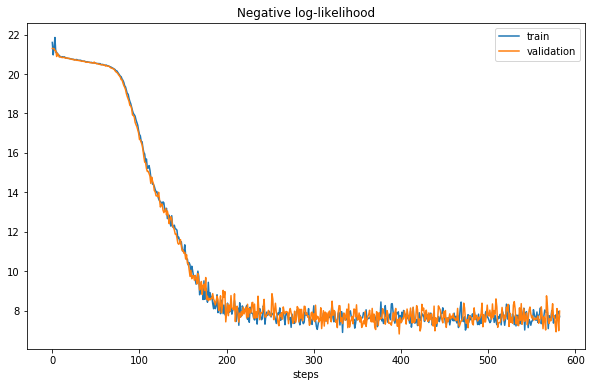

In [27]:
# plot training and validation losses
agg_tr_loss = [sum(l) for l in tr_logs]
agg_val_loss = [sum(l) for l in val_logs]
plt.plot(agg_tr_loss)
plt.plot(agg_val_loss)
plt.legend(['train','validation'])
plt.title('Negative log-likelihood')
plt.xlabel('steps')


In [23]:
# compute reaction probabilities for event records in the test split 
ground_truth = [[] for i in range(len(attribute_mapper[reaction_var]))]
predictions = [[] for i in range(len(attribute_mapper[reaction_var]))]
for j, test_batch_data in enumerate(dl_test):
        
    test_output_distr = model(test_batch_data) 
    
    losses = {}
    for var, distr in output_distr.items():
        predictions[var] += test_output_distr[var].probs.detach().numpy().tolist() 
        ground_truth[var] += test_batch_data[reaction_var][var].detach().numpy().tolist() 

    test_agg_l = log_loss(test_output_distr,test_batch_data[reaction_var])
    test_loss = 0
    for var, l in test_agg_l.items():
        test_loss += l
            

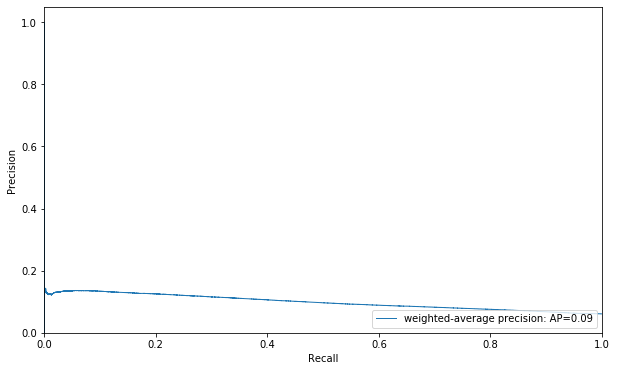

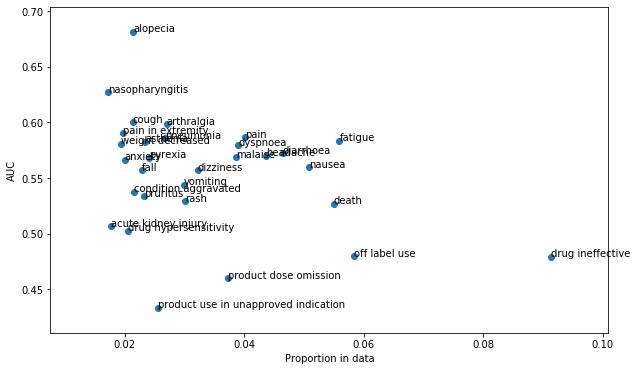

<Figure size 720x432 with 0 Axes>

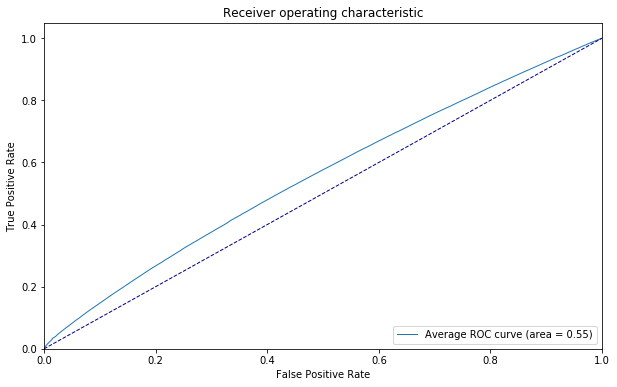

In [26]:
# compute performance metrics on test set predictions
class_mapper = {attribute_mapper[reaction_var][i]:i for i in range(len(attribute_mapper[reaction_var]))}

plot_precision_recall(np.array(ground_truth).T, np.array(predictions).T, class_mapper, reaction_count[sel_reaction_inds])
plot_roc_results(np.array(ground_truth).T, np.array(predictions).T, class_mapper, reaction_count[sel_reaction_inds])